In [126]:
using PyPlot, JuMP, Gurobi, PyCall

# BTB Model

In [66]:
n_workers = 3
n_task_types = 5
n_tasks_per_type = 10
quotas = rand(1:n_tasks_per_type, n_task_types)
horizon = maximum(quotas)
initial_task_lengths = rand(1:n_tasks_per_type, n_task_types)
min_task_lengths = max.(1, initial_task_lengths - rand(1:n_tasks_per_type, n_task_types))
task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:n_task_types, T in 1:horizon]

5×5 Array{Int64,2}:
 5   9  13  17  21
 1   2   3   4   5
 6  11  15  18  20
 9  17  24  30  35
 3   5   7   9  11

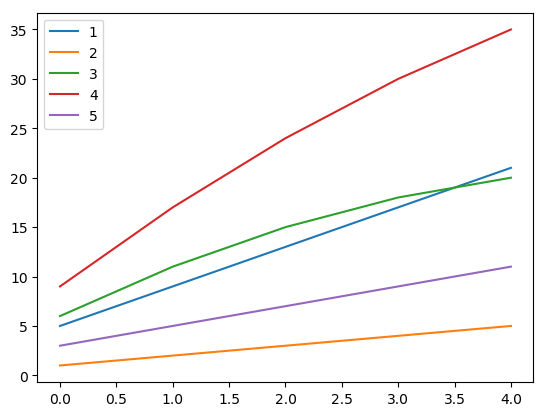

In [67]:
plot(task_bundle_times')
legend(1:n_task_types)
;

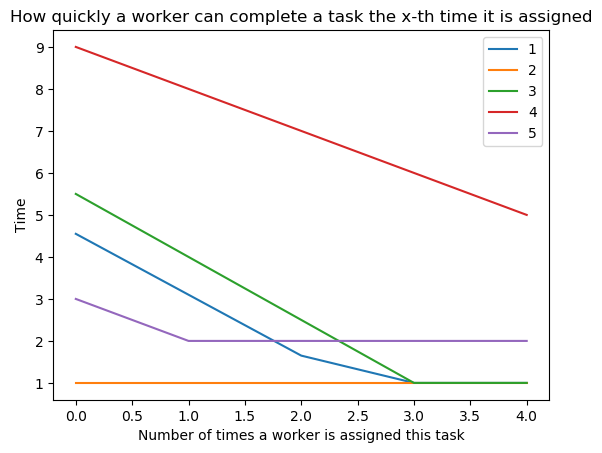

In [68]:
learning_speed = rand(1:0.05:1.75, n_task_types)
min_task_lengths = max.(1, initial_task_lengths - rand(1:10, n_task_types))
task_completion_speed = [(max.(min_task_lengths[j], initial_task_lengths[j]-T*learning_speed[j])) for j in 1:n_task_types, T in 1:horizon]

plot(task_completion_speed')
legend(1:n_task_types); xlabel("Number of times a worker is assigned this task"); ylabel("Time")
title("How quickly a worker can complete a task the x-th time it is assigned")
;

In [72]:
task_completion_speed
quotas

5-element Array{Int64,1}:
 3
 4
 2
 5
 1

In [73]:
L = rand(0:maximum(quotas), n_workers, n_task_types)

3×5 Array{Int64,2}:
 1  4  4  3  2
 0  5  4  3  5
 2  1  1  2  3

In [81]:
# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
task_dur = zeros(n_workers, n_task_types)

# labels is a matrix where for a worker i and task type j, the [i, j] index contains the string representation
# of the number of tasks completed
labels = Array{String}(n_workers, n_task_types)

for i=1:n_workers
    for j=1:n_task_types
        labels[i, j] = "$(L[i, j]) Tasks"
        for k=1:L[i, j]
            task_dur[i, j] = task_dur[i, j] + task_completion_speed[j, k]
        end
    end
end

task_dur
labels

3×5 Array{String,2}:
 "1 Tasks"  "4 Tasks"  "4 Tasks"  "3 Tasks"  "2 Tasks"
 "0 Tasks"  "5 Tasks"  "4 Tasks"  "3 Tasks"  "5 Tasks"
 "2 Tasks"  "1 Tasks"  "1 Tasks"  "2 Tasks"  "3 Tasks"

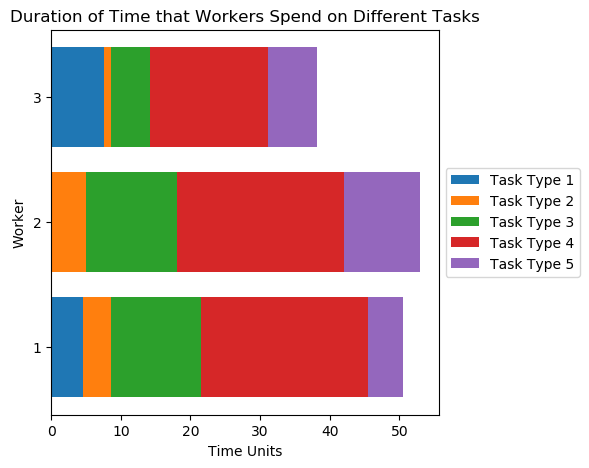

In [142]:
plot_task_dur(n_workers, n_task_types, task_dur);

# Variety Assignment Model

In [21]:
# Task/Worker Parameters
###############################

## We require 5 of task_1, 1 of task_2, etc.
N = [5,4,10]  #tasks
n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
#W = hcat(ones(w), 3*ones(w), 2*ones(w)) # 1 worker who completes task 1 in 1 time, tasks 2 in three time, etc.
W = [1 3 4;
     5 6 1;]
w = size(W,1) #number of workers


T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

###############################

m = Model(solver=GurobiSolver())

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                #@constraint(m, [i=1:n,j=1:v,k=1:w, t=1:T], z[i,j,k,t+l] == x[i,j,k,t] for l=1:W[k,j])
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
#@expression(m, end_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t+W[i,k]) for t=1:T))
@expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
#@constraint(m, [j=1:n, k=1:v, i=1:w], last >= end_t[j,k,i])
@constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])


@objective(m, Min, last)


@time(solve(m))
getobjectivevalue(m)

Academic license - for non-commercial use only
Optimize a model with 29849 rows, 13681 columns and 86080 nonzeros
Variable types: 1 continuous, 13680 integer (13680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 110.0000000
Presolve removed 19146 rows and 3507 columns
Presolve time: 0.66s
Presolved: 10703 rows, 10174 columns, 65321 nonzeros
Variable types: 0 continuous, 10174 integer (10173 binary)

Root relaxation: objective 2.713635e-01, 10724 iterations, 2.42 seconds
Total elapsed time = 5.40s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.27136    0 2718  110.00000    0.27136   100%     -    5s
H    0     0                      53.0000000    0.27136  99.5%     -    6s
H    0     0                      21.00

17.0

In [22]:
schedule = getvalue(z)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
task_dur = zeros(size(W, 1), v)

for i=1:w
    for j=1:v
        task_dur[i, j] = sum(schedule[:, j, i, :])
    end
end

task_dur

2×3 Array{Float64,2}:
 5.0  9.0   0.0
 0.0  6.0  10.0

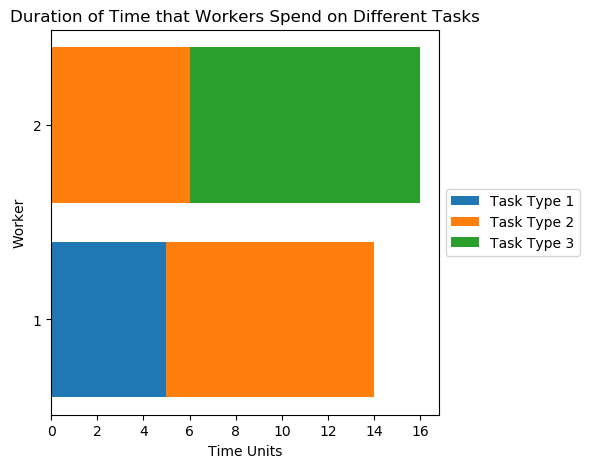

In [23]:
plot_task_dur(w, n, task_dur);

# Simple Assignment

In [143]:
#########################
# Simple Assignment Model
#########################
N = 50 # tasks
M = 9 # workers
T = N #upper bound on project completion

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:N, 1:M, 1:T], Bin)
@variable(m, last)

# due to the following two constraints, this just selects the time
# when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
@expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

# each task is only worked on once
@constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

# min { max_j end_t[j] }
@constraint(m, [j=1:N], last >= start_t[j] + 1)

@objective(m, Min, last)

solve(m)

println("Minimum time to complete tasks: ", getvalue(last))

Academic license - for non-commercial use only
Minimum time to complete tasks: 7.0


In [144]:
schedule = getvalue(x)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
# task_dur = sum(schedule[:, i, :] for i=1:M)
task_dur = zeros(M)

for i=1:M
    task_dur[i] = sum(schedule[:, i, :])
end

task_dur

9-element Array{Float64,1}:
 6.0
 6.0
 6.0
 6.0
 5.0
 5.0
 5.0
 5.0
 6.0

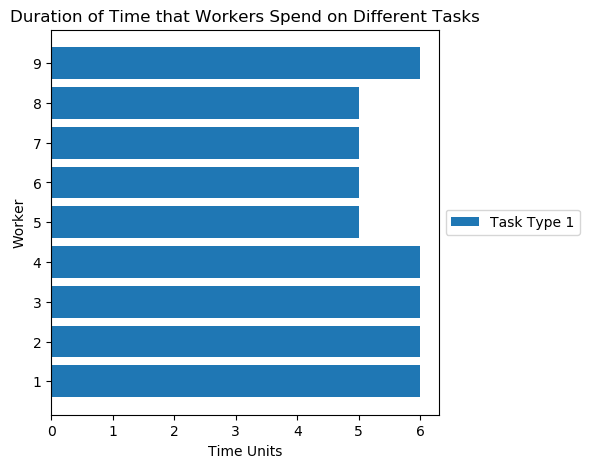

In [145]:
plot_task_dur(M, 1, task_dur);

In [141]:
# This function plots a horizontal bar graph to help visualize task assignment/complete for each worker over time.
# This function accepts arguments for the number of workers, n_workers, the number of task types, n_task_types, and 
# a matrix where the rows represent workers and the columns represent the duration that worker worked on a 
# certain task type, task_dur.

function plot_task_dur(n_workers, n_task_types, task_dur)
    ind = 1:n_workers
    width = 0.35

    ax = Array{Any}(size(task_dur, 2))
    
    lft = zeros(n_workers)
    
    figure(figsize=[5, 5])
    for j=1:size(task_dur, 2)
        ax[j] = barh(ind, task_dur[:, j], left=lft, label="Task Type $j")
        lft = lft + task_dur[:, j]
    end
    
    ylabel("Worker")
    xlabel("Time Units")
    title("Duration of Time that Workers Spend on Different Tasks")
    legend(loc="center left", bbox_to_anchor=(1, 0.5))
    yticks(1:n_workers)
end
;

In [ ]:
#     zi = zip(ax[:])  
#     for r1, r2 in zip(ax1, ax2):
#     h_tot = 0
#     for r in ax
#         h = r.get_height()
#         h_tot = h_tot + h
#         text(r.get_x() + r2[1] / 2., h_tot / 2., "%d" % h, ha="center", va="center", color="white", fontsize=16, fontweight="bold")
#     end